# The memory updating mode

In this notebook, we show how using `minibn` to implement custom updating modes with the memory updating mode as defined in the section "Context-dependent updating modes".

In [1]:
from colomoto.minibn import *

This notebook has been executed using the docker image `colomoto/colomoto-docker:2022-07-01`

A custom updating mode can be implemented by extending the abstract `UpdateModeDynamics` class. There, the `__call__` method should be defined: it takes as argument one configuration, and must return an iterator over the next configurations.

Here, the `MemoryDynamics` class takes additional argument the set of automata which will be updated asynchronously (denoted by $\bar d$ in the chapter).

In [2]:
class MemoryDynamics(UpdateModeDynamics):
    def __init__(self, A, model, **opts):
        """
        A is the subset of automata updated asynchronously
        """
        super().__init__(model, **opts)
        self.A = A
    
    def __call__(self, x):
        y = self.model(x)   # f(x)
        D = {a for a in self.A if y[a]-x[a]<0} # automata in A changing from 1 to 0
        U = tuple((a for a in self.nodes if a not in D)) # other automata
        z = x.copy()
        for i in U:   # apply update on automata in U
            z[i] = y[i]
        yield z
        for k in range(1, len(D)+1): # apply update in each subset of D
            for I in itertools.combinations(D, k):
                w = z.copy()
                for i in I:
                    w[i] = y[i]
                yield w

In [3]:
f = BooleanNetwork({
    "x1": "!x3",
    "x2": "x2 & (x1 | x3)",
    "x3": "!x1"
})
f

x1 <- !x3
x2 <- x2&(x1|x3)
x3 <- !x1

The following code reproduces Fig 6.8(b):

# computing graph layout...


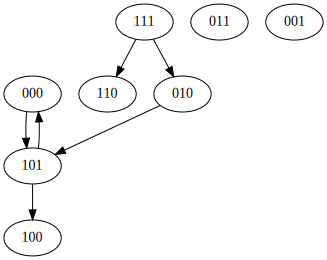

In [4]:
MemoryDynamics({"x1"}, f).dynamics()